# T<sub>2</sub> Hahn Characterization (CPMG)

The purpose of the $T_2$ Hahn Echo experiment is to determine $T_2$ qubit property. 

In this experiment, we would like to get a more precise estimate of the qubit's decay time. $T_2$ represents the amount of time required for a single qubit Bloch vector projection on the XY plane, to fall to approximately 37% ($\frac{1}{e}$) of its initial amplitude.<br>
In <a href="./t2ramsey_characterization.ipynb">Ramsey Experiment</a> we were introduced to the term <I>detuning frequency</I> (The difference between the frequency used for the control rotation, and the precise frequency).
<br>Hahn Echo experiment and CPMG sequence are experiments to estimate $T_2$ which are robust to the <I>detuning frequency</I>.
The decay in amplitude causes the probability function to take the following form:<br>
$$f(t) = A \cdot e^{-\frac{t}{T_2}}+ B$$
The difference between Hahn Echo and CPMG sequence is that in Hahn Echo experiment, there is only one echo sequence while in CPMG there are multiple echo sequences.

## 1. Decoherence Time
Decoherence time is the time taken for off-diagonal components of the density matrix to fall to approximately 37% ($\frac{1}{e}$). For $t\gg T_2$, the qubit statistics behave like a random bit. It gets the value of `0` with probability of $p$ and the value of `1` with probability of $1-p$.

Since the qubit is exposed to other types of noise (like <a href="./t1.ipynb"> T<sub>1</sub></a>), we are using $Rx(\pi)$ pulses for decoupling and to solve our inaccuracy for the qubit frequency estimation.

In [1]:
import qiskit
from qiskit_experiments.library.characterization.t2hahn import T2Hahn

The circuit used for an experiment with $N$ echoes comprises the following components:

&emsp; 1.$Rx\left(\frac{\pi}{2} \right)$ gate <br>
&emsp; 2. $N$ times Echo sequence : <br>
&emsp; &emsp; (a) $Delay \left(t_{0} \right)$ gate <br>
&emsp; &emsp; (b) $Rx \left(\pi \right)$ gate <br>
&emsp; &emsp; (c) $Delay \left(t_{0} \right)$ gate <br>
&emsp; 3. $Rx \left(\pm \frac{\pi}{2} \right)$ gate (sign depends on the number of echoes) <br>
&emsp; 4. Measurement gate

The user provides as input a series of delays in seconds. During the delay, we expect the qubit to precess about the z-axis. Because of the echo gate ($Rx(\pi)$) for each echo, the angle after the delay gates will be $\theta_{new} = \theta_{old} + \pi$. After waiting the same delay time, the angle will be approximately $0$ or $\pi$. By varying the extension of the delays, we get a series of decaying measurements. We can draw the graph of the resulting function and can analytically extract the desired values.

In [2]:
qubit = 0
conversion_factor = 1e-6 # our delay will be in micro-sec
delays = list(range(0, 50, 1) )
delays = [float(_) * conversion_factor for _ in delays]
number_of_echoes = 1

# Create a T2Hahn experiment. Print the first circuit as an example
exp1 = T2Hahn(qubit=qubit, delays=delays, num_echoes=number_of_echoes)
print(exp1.circuits()[0])

     ┌─────────┐┌───────────────┐┌───────┐┌───────────────┐┌─────────┐┌─┐
  q: ┤ Rx(π/2) ├┤ Delay(0.0[s]) ├┤ Rx(π) ├┤ Delay(0.0[s]) ├┤ Rx(π/2) ├┤M├
     └─────────┘└───────────────┘└───────┘└───────────────┘└─────────┘└╥┘
c: 1/══════════════════════════════════════════════════════════════════╩═
                                                                       0 


We run the experiment on a simple, simulated backend, tailored specifically for this experiment.

In [3]:
from qiskit_experiments.test.t2hahn_backend import T2HahnBackend

estimated_t2hahn = 20 * conversion_factor
# The behavior of the backend is determined by the following parameters
backend = T2HahnBackend(
    t2hahn=[estimated_t2hahn],
    frequency=[100100],
    initialization_error=[0.0],
    readout0to1=[0.02],
    readout1to0=[0.02],
)

The resulting graph will have the form:
$f(t) = A \cdot e^{-\frac{t}{T_2}}+ B$
where *t* is the delay and $T_2$ is the decay factor.

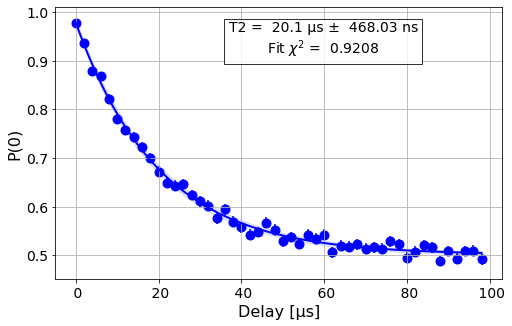

In [4]:
exp1.analysis.set_options(p0=None, plot=True)
expdata1 = exp1.run(backend=backend, shots=2000)
expdata1.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
display(expdata1.figure(0))

In [5]:
# Print results
for result in expdata1.analysis_results():
    print(result)

DbAnalysisResultV1
- name: @Parameters_T2HahnAnalysis
- value: [4.77306456e-01 5.01013038e-01 2.00569581e-05] ± [3.60925695e-03 2.92038248e-03 4.68026484e-07]
- χ²: 0.9207937705047796
- quality: good
- extra: <4 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: T2
- value: 2.0056958094880182e-05 ± 4.6802648351047525e-07 s
- χ²: 0.9207937705047796
- quality: good
- device_components: ['Q0']
- verified: False


### 2. Providing initial user estimates
The user can provide initial estimates for the parameters to help the analysis process. In the initial guess, the keys `{amp, tau, base}` correspond to the parameters `{A, T_2, B}` respectively.<br>
Because the curve is expected to decay toward $0.5$, the natural choice for parameter $B$ is $0.5$. When there is no $T_2$ error, we would expect that the probability to measure `1` is $100\%$, therefore we will guess that A is $0.5$. In this experiment, `t2hahn` is the parameter of interest. Good estimate for it is the value computed in previous experiments on this qubit or a similar value computed for other qubits.

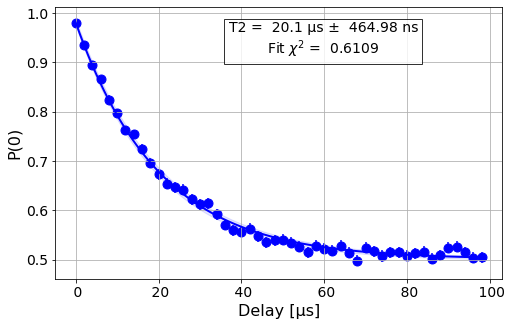

In [6]:
exp_with_p0 = T2Hahn(qubit=qubit, delays=delays, num_echoes=number_of_echoes)
exp_with_p0.analysis.set_options(p0={"amp": 0.5, "tau": estimated_t2hahn, "base": 0.5})
expdata_with_p0 = exp_with_p0.run(backend=backend, shots=2000)
expdata_with_p0.block_for_results()

# Display fit figure
display(expdata_with_p0.figure(0))

In [7]:
# Print results
for result in expdata_with_p0.analysis_results():
    print(result)

DbAnalysisResultV1
- name: @Parameters_T2HahnAnalysis
- value: [4.79645080e-01 5.01025155e-01 2.01217480e-05] ± [3.58419367e-03 2.92444090e-03 4.64978519e-07]
- χ²: 0.6109365214541765
- quality: good
- extra: <4 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: T2
- value: 2.0121748034379643e-05 ± 4.6497851904598897e-07 s
- χ²: 0.6109365214541765
- quality: good
- device_components: ['Q0']
- verified: False


### 3. Number of echoes
The user can provide the number of echoes that the circuit will perform. This will determine the amount of delay and echo gates. As the number of echoes increases, the total time of the circuit will grow. The echoes decrease the effects of $T_{1}$ noise and frequency inaccuracy estimation. Due to that, the Hahn Echo experiment improves our estimate for $T_{2}$. In the following code, we will compare results of the Hahn experiment with `0` echoes and `1` echoes. The analysis should fail for the circuit with `0` echoes. In order to see it, we will add frequency to the qubit and see how it affect the estimated $T_2$. <br>
Note, that the provided delay time is the for each delay in the circuit and not the total time.

In [8]:
import numpy as np

qubit2 = 0
# set the desired delays
conversion_factor = 1e-6

# The delays aren't equally spaced due the behavior of exponential decay curve where the change in the result
# in earlier times is larger than later times. In addition, since the total delay is 'delay * 2 * num_of_echoes',
# the construction of the delays for each experiment will be different, such that their total length will be the same.

# Delays for Hahn Echo Experiment with 0 echoes
delays2 = np.append(
                    (np.linspace(0.0, 51.0, num=26)).astype(float),
                    (np.linspace(53, 100.0, num=25)).astype(float),
                )

delays2 = [float(_) * conversion_factor for _ in delays2]

# Delays for Hahn Echo Experiment with 4 echoes
delays3 = np.append(
                    (np.linspace(0.0, 25.5, num=26)).astype(float),
                    (np.linspace(26.5, 50, num=25)).astype(float),
                )
# delays3 = np.append(
#                     (np.linspace(0.0, 6.375, num=26)).astype(float),
#                     (np.linspace(6.625, 12.5, num=25)).astype(float),
#                 )
delays3 = [float(_) * conversion_factor for _ in delays3]

num_echoes = 1
estimated_t2hahn2 = 20 * conversion_factor

# Create a T2Hahn experiment with 0 echoes
exp2_0echoes = T2Hahn(qubit2, delays2, num_echoes=0)
exp2_0echoes.analysis.set_options(p0={"amp": 0.5, "tau": estimated_t2hahn2, "base": 0.5})
print("The first circuit of hahn echo experiment with 0 echoes:")
print(exp2_0echoes.circuits()[0])

# Create a T2Hahn experiment with 1 echoes. Print the first circuit as an example
exp2_1echoes = T2Hahn(qubit2, delays3, num_echoes=num_echoes)
exp2_1echoes.analysis.set_options(p0={"amp": 0.5, "tau": estimated_t2hahn2, "base": 0.5})
print("The first circuit of hahn echo experiment with 1 echoes:")
print(exp2_1echoes.circuits()[0])


The first circuit of hahn echo experiment with 0 echoes:
     ┌─────────┐┌───────────────┐┌──────────┐┌─┐
  q: ┤ Rx(π/2) ├┤ Delay(0.0[s]) ├┤ Rx(-π/2) ├┤M├
     └─────────┘└───────────────┘└──────────┘└╥┘
c: 1/═════════════════════════════════════════╩═
                                              0 
The first circuit of hahn echo experiment with 1 echoes:
     ┌─────────┐┌───────────────┐┌───────┐┌───────────────┐┌─────────┐┌─┐
  q: ┤ Rx(π/2) ├┤ Delay(0.0[s]) ├┤ Rx(π) ├┤ Delay(0.0[s]) ├┤ Rx(π/2) ├┤M├
     └─────────┘└───────────────┘└───────┘└───────────────┘└─────────┘└╥┘
c: 1/══════════════════════════════════════════════════════════════════╩═
                                                                       0 


Hahn Echo with 0 echoes:


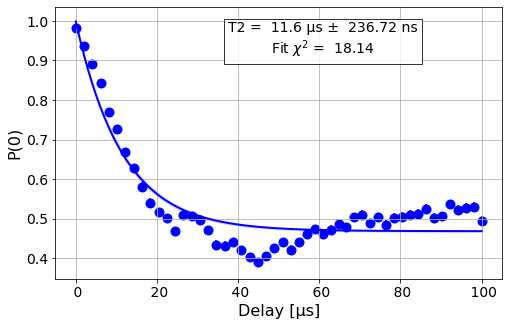

Hahn Echo with 1 echoe:


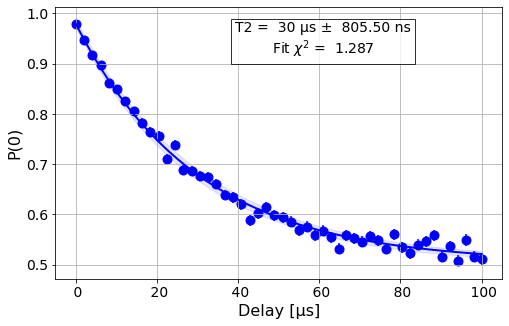

In [9]:
from qiskit_experiments.test.t2hahn_backend import T2HahnBackend

estimated_t2hahn2 = 30 * conversion_factor
detuning_frequency = 2 * np.pi * 10000

# The behavior of the backend is determined by the following parameters
backend2 = T2HahnBackend(
    t2hahn=[estimated_t2hahn2],
    frequency=[detuning_frequency],
    initialization_error=[0.0],
    readout0to1=[0.02],
    readout1to0=[0.02],)

# Analysis for Hahn Echo experiemnt with 0 echoes.
expdata2_0echoes = exp2_0echoes.run(backend=backend2, shots=2000)
expdata2_0echoes.block_for_results()  # Wait for job/analysis to finish.

# Analysis for Hahn Echo experiemnt with 1 echo
expdata2_1echoes = exp2_1echoes.run(backend=backend2, shots=2000)
expdata2_1echoes.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
print("Hahn Echo with 0 echoes:")
display(expdata2_0echoes.figure(0))
print("Hahn Echo with 1 echoe:")
display(expdata2_1echoes.figure(0))

We see that the estimate $T_2$ is different in the two plots. The mock backend for this experiment used $T_{2} = 30[\mu s]$, which is close to the estimate of the 1 echo experiment.

In [10]:
import qiskit.tools.jupyter
%qiskit_copyright